<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/jax_cosmo/blob/master/docs/notebooks/jax-cosmo-intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to jax-cosmo

Authors:
  - [@EiffL](https://github.com/EiffL) (Francois Lanusse)

### Overview

`jax-cosmo` brings the power of automatic differentiation and XLA execution
to cosmological computations, all the while preserving the readability and human
friendliness of Python / NumPy.

This is made possible by the [JAX](https://jax.readthedocs.io/en/latest/index.html) framework, which can be summarised as JAX = NumPy + autograd + GPU/TPU. We
encourage the interested reader to follow this [introduction to JAX](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html) but it will not be necessary to follow this notebook.


### Learning objectives

In this short introduction we will cover:
  - How to define computations of **2pt functions**
  - How to execute these computations on **GPU** (spoiler alert, you actually don't need to do anything, it happens automatically)
  - How to **take derivatives** of any quantities by automatic differentation
  - And finally, how to piece all of this together for efficient and reliable **Fisher matrices**.





## Installing and importing jax-cosmo

One of the important aspects of `jax-cosmo` is that it is entirely Python-based
so it can trivially be installed without compiling or downloading any third-party tools.

Here is how to install the current release on your system:

In [1]:
# Installing jax-cosmo
#!pip install --quiet jax-cosmo

For efficient computation on GPU (if you have one), you might want to make sure that JAX itself is installed with the proper GPU-enabled backend. See [here](https://github.com/google/jax#installation) for more instructions.

Now that `jax-cosmo` is installed, let's import it along with JAX tools:

In [2]:
%pylab inline
import jax
import jax_cosmo as jc
import jax.numpy as np

Populating the interactive namespace from numpy and matplotlib


**Note that we import the JAX version of NumPy here**. That's all that you have to do, any numpy functions you will use afterwards will be JAX-accelerated and differentiable.

And for the purpose of this tutorial we also define a few plotting functions in the cell bellow, please run it.

In [3]:
#@title Defining some plotting functions [run me]

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos,  nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  vals, vecs = eigsorted(cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  ellip = Ellipse(xy=pos, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[0] - s1, pos[0] + s1)
  ax.set_ylim(pos[1] - s2, pos[1] + s2)
  plt.draw()
  return ellip

## Defining a Cosmology and computing background quantities

We'll beginning with the basics, let's define a cosmology:


In [4]:
# Create a cosmology with default parameters
cosmo = jc.Planck15()

In [5]:
# Alternatively we can override some of the defaults
cosmo_modified = jc.Planck15(h=0.7)

In [6]:
# Parameters can be easily accessed from the cosmology object
cosmo.h

0.6774

All background quantities can be computed from the `jax_cosmo.background` module, they typically take the cosmology as first argument, and a scale factor
argument if they are not constant.

/home/ben.horowitz/flowpm/lib/python3.6/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/home/ben.horowitz/flowpm/lib/python3.6/site-packages/jax/lax/lax.py:5385: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/ben.horowitz/flowpm/lib/python3.6/site-packages/jax/lax/lax.py:5385: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas 

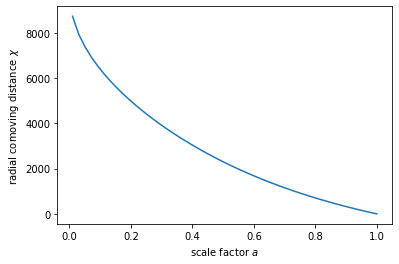

In [7]:
# Let's define a range of scale factors
a = np.linspace(0.01, 1.)

# And compute the comoving distance for these scale factors 
chi = jc.background.radial_comoving_distance(cosmo, a)

# We can now plot the results:
plot(a, chi)
xlabel(r'scale factor $a$')
ylabel(r'radial comoving distance $\chi$');

In [8]:
# Not sure what are the units of the comoving distance? just ask:
#jc.background.radial_comoving_distance?

## Defining redshift distributions

On our path to computing Fisher matrices, we need to be able to express redshift distrbutions. In `jax-cosmo` n(z) are parametrized functions which can
be found in the `jax_cosmo.redshift` module. 

For the purpose of this tutorial, let's see how to define a Smail type distribution:
$$ n(z) = z^a \exp(- (z/z_0)^b) $$
which depends on 3 parameters:

In [9]:
# You can inspect the documentation to see the 
# meaning of these positional arguments
nz1 = jc.redshift.smail_nz(1., 2.,  1.)
nz2 = jc.redshift.smail_nz(1., 2.,  0.5)

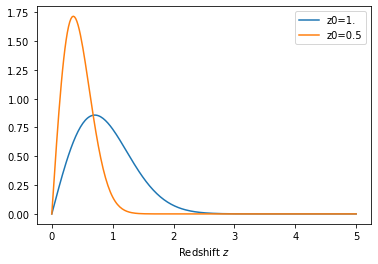

In [10]:
# And let's plot it
z = np.linspace(0,5,256)

# Redshift distributions are callable, and they return the normalized distribution
plot(z, nz1(z), label='z0=1.')
plot(z, nz2(z), label='z0=0.5')
legend();
xlabel('Redshift $z$');

In [11]:
# We can check that the nz is properly normalized
jc.scipy.integrate.romb(nz1, 0., 5.)

DeviceArray(0.99999976, dtype=float32)

Nice :-D 

## Defining probes and computing angular $C_\ell$

Let's now move on to define lensing and clustering probes using these two n(z).
In `jax-cosmo` a probe/tracer of a given type, i.e. lensing, contains a series of parameters, like redshift distributions, or galaxy bias. Probes are hosted in
the `jax_cosmo.probes` module.

$C_\ell$ computations will then take as argument a list of probes and will compute all auto- and cross- correlations between all redshift bins of all probes. 

In [12]:
# First we define a list of redshift bins
nzs = [nz1, nz2]

In [45]:
import jax.numpy as np

#@jit
def mag_bias(z):
    #print("mag_bias")
    return np.sqrt(1. + z)*10.0

In [46]:
mag_bias

<function __main__.mag_bias(z)>

In [47]:
# And now we define 2 probes 
probes_nomag = [ 
           jc.probes.NumberCounts(nzs, jc.bias.constant_linear_bias(1.))  ]

probes_mag = [ 
           jc.probes.NumberCounts(nzs, jc.bias.constant_linear_bias(1.0),mag_bias=mag_bias)  ]


In [48]:
mb = jc.probes.NumberCounts(nzs, jc.bias.constant_linear_bias(1.0),mag_bias=mag_bias)

In [49]:
mb.config["mag_bias"](3.0)

DeviceArray(20., dtype=float32)

Given these probes, we can now compute tomographic angular power spectra for these probes using the `angular_cl` tools hosted in the `jax_cosmo.angular_cl` module. For now, all computations are done under the Limber approximation.

In [50]:
# Let's define a range of \ell
ell = np.logspace(1,3)

# And compute the data vector
cls_nomag = jc.angular_cl.angular_cl(cosmo, ell, probes_nomag)
cls_mag = jc.angular_cl.angular_cl(cosmo, ell, probes_mag)

TypeError: Argument '<function mag_bias at 0x7f8ca82aa1e0>' of type <class 'function'> is not a valid JAX type

In [ ]:
# Let's check the shape of these Cls
cls_mag[1]-cls_nomag[1]

We see that we have obtained 10 spectra, each of them of size 50, which is the length of the $\ell$ vector. They are ordered first by probe, then by redshift bin. So the first cl is the lensing auto-spectrum of the first bin

In [ ]:
# This is for instance the first bin auto-spectrum 
for cl in cls:
    loglog(ell, cl)
    ylabel(r'$C_\ell$')
    xlabel(r'$\ell$');
    title(r'Angular $C_\ell$');


In addition to the data vector, we can also compute the covariance matrix using the tools from that module. Here is an example:

In [ ]:
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, probes);

The data vector from this function is in a flattened shape so that it can be multiplied by the covariance matrix easily.

In [ ]:
semilogy(mu);

In [ ]:
figure(figsize=(10,10))
imshow(np.log10(cov+1e-11),cmap='gist_stern');

## Where the wild things are: Automatic Differentiation

Now that we know how to compute various quantities, we can move on to the amazing part, computing gradients automatically by autodiff. As an example, we
will demonstrate how to analytically **compute Fisher matrices, without finite differences.** But gradients are usefull for a wide range of other applications.


We begin by defining a Gaussian likelihood function for the data vector we have 
obtained at the previous step. And we make this likelihood function depend on an array of parameters, `Omega_c`, `sigma_8`.
 



In [ ]:
# Let's define a parameter vector for Omega_cdm, sigma8, which we initialize 
# at the fiducial cosmology used to produce the data vector.
data = mu;
params = np.array([cosmo.Omega_c, cosmo.sigma8])

# Note the `jit` decorator for just in time compilation, this makes your code
# run fast on GPU :-)
@jax.jit
def likelihood(p):
  # Create a new cosmology at these parameters
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])

  # Compute mean and covariance of angular Cls
  m, C = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, probes)

  # Return likelihood value assuming constant covariance, so we stop the gradient
  # at the level of the precision matrix, and we will not include the logdet term
  # in the likelihood
  P = jax.lax.stop_gradient(np.linalg.inv(C))
  r = data - m
  return -0.5 * (r.T @ P @ r)

In [ ]:
# Computing the likelihood at our fiducial params, we should get 0 since we don't
# have the normalization term
print(likelihood(params))
%timeit likelihood(params).block_until_ready()

This is an illustration of evaluating the full likelihood. Note that because we 
used the `@jax.jit` decorator on the likelihood, this code is being compiled to 
and XLA expression that runs automatically on the GPU if it's available. 


But now that we have a likelihood function of the parameters, we can manipulate
it with JAX, and in particular take the second derivative of this likelihood 
with respect to the input cosmological parameters. This Hessian, is just minus 
the Fisher matrix when everything is nice and Gaussian around the fiducial comology.


So this mean, by JAX automaticatic differentiation, we can analytically derive
the Fisher matrix in just one line:


In [ ]:
# Compile a function that computes the Hessian of the likelihood
hessian_loglik = jax.jit(jax.hessian(likelihood))

# Evalauate the Hessian at fiductial cosmology to retrieve Fisher matrix
F = - hessian_loglik(params)

What we are doing on the line above is taking the Hessian of the likelihood function, and evaluating at the fiducial cosmology. We surround the whole thing 
with a `jit` instruction so that the function gets compiled and evaluated in one
block in the GPU.

Compiling the function is not instantaneous, but once compiled, it becomes  fast but the evaluation is:

In [ ]:
%timeit hessian_loglik(params).block_until_ready()

And best of all: **No derivatives were harmed by finite differences in the computation of this Fisher!**

We can now try to plot it:

In [ ]:
# We can now plot contours obtained with this 
plot_contours(F, params, fill=False);
xlabel('Omega_m')
ylabel('sigma8')

And just to reinforce this point and demonstrate further audodiff magic, let's try to derive the same matrix differently, using the usual formula for constant
covariance:

$$ F_{\alpha, \beta} = \sum_{i,j} \frac{d \mu_i}{d \theta_\alpha} C^{-1}_{i,j} \frac{d \mu_j}{d \theta_\beta} $$

What we need in this expression, is the covariance matrix, which we already have
and the Jacobian of the mean with respect to parameters. Normally you would need to use finite differencing, but luckily we can get that easily with JAX:

In [ ]:
# We define a parameter dependent function that computes the mean
def mean_fn(p):
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])
  # Compute signal vector
  m = jc.angular_cl.angular_cl(cosmo, ell, probes)
  return m.flatten() # We want it in 1d to operate against the covariance matrix

In [ ]:
# We compute it's jacobian with JAX, and we JIT it for efficiency
jac_mean = jax.jit(jax.jacfwd(mean_fn))

In [ ]:
# We can now evaluate the jacobian at the fiducial cosmology
dmu = jac_mean(params)

In [ ]:
dmu.shape

In [ ]:
# For fun, we can alsi time it
%timeit jac_mean(params).block_until_ready()

Getting these gradients is the same order of time than evaluating the forward function!

In [ ]:
# Now we can compose the Fisher matrix:
F_2 = np.einsum('ia, ij, jb', dmu, np.linalg.inv(cov), dmu)

In [ ]:
# We can now plot contours obtained with this 
plot_contours(F, params, fill=False,color='black',lw=4);
plot_contours(F_2, params, fill=False, color='red', lw=4, linestyle='dashed');
xlabel('Omega_m')
ylabel('sigma8');

The red dashed is our second derivation of the Fisher matrix using the jacobian, the black contour underneath is our first derivation simply taking the Hessian of the likelihood.

They agree perfectly, and they should, because they are both analytically computed.

## Conclusions and going further

We have covered some of the most important points of `jax-cosmo`, feel free to 
go through the [design document](https://github.com/DifferentiableUniverseInitiative/jax_cosmo/blob/master/design.md) for background and further explanations of how things work. You can also follow this [JAX document](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html) to go deeper into JAX.


`jax-cosmo` is still very young and lacks many features, but hopefuly this notebook demonstrates the power of automatic differentiation, and given that the entire code is in simple Python, feel free to contribute missing features that would be necessary for your work ;-) 